In [207]:
%%capture
%load_ext autoreload
%autoreload 2

from glob import glob
from functools import reduce
from tqdm import tqdm
import sys

from sklearn.naive_bayes import GaussianNB

from pilot import *
%matplotlib inline
plt.style.use("ggplot")

LOGDIR = os.path.join(os.getcwd(), 'logs')

In [179]:
NBLOCKS = 5
NTRIALS = 10

dims = [10, 100, 200]
scales = [0.25, 0.50, 0.75]
experiments = []
for d in dims:
    for s in scales:
        experiments.append({'ndims': d, 'scale': s})

In [180]:
def label_to_binary(label):
    if label == 'bivimias':
        return 0
    elif label == 'lorifens':
        return 1
    else:
        raise ValueError('Unknown label: {}'.format(label))

In [181]:
def run_experiment(x, feat_type, nblocks=NBLOCKS, ntrials=NTRIALS, logdir=LOGDIR, seed=None):
    if seed is not None:
        np.random.seed(seed)
    config = get_config(nblocks=nblocks, ntrials=ntrials, ndims=x['ndims'], std=x['scale'], print_feedback=True)
    blocks = get_blocks(config)
    return simulate_learning(blocks, config, feat_type)

In [182]:
def simulate_learning(blocks, config, feat_type='z'):
    
    if feat_type == 'z':
        ndims = 200
    elif feat_type == 'img':
        ndims = 12288
    else:
        raise ValueError('Unrecognized feat_type: {}'.format(feat_type))
        
    X_tot = np.zeros((NBLOCKS * NTRIALS, ndims))
    y_tot = np.zeros((NBLOCKS * NTRIALS))
    
    pred_blocks = []
    for b, block in enumerate(blocks):
#         print('Running block {}...'.format(b))
        preds = []
        for i, sample in enumerate(block):
            curr_idx = (b * NTRIALS) + i
            
            X = sample[feat_type].reshape(1, -1)
            y = np.array(label_to_binary(sample['category'])).reshape((1,))
            
            if b == 0 and i == 0:
                # First guess is random
                p = np.array([float(np.random.binomial(1, p=0.5))])
            else:
                # Need to re-declare model every iteration, since partial_fit not working
                model = GaussianNB()
                model.fit(X_tot[:curr_idx], y_tot[:curr_idx])
                p = model.predict(X)
            
            preds.append((int(p), int(y)))
            
            X_tot[curr_idx] = X
            y_tot[curr_idx] = y
            
        pred_blocks.append(preds)
            
            
    return pred_blocks

{'ndims': 10, 'scale': 0.25}


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

{'ndims': 10, 'scale': 0.5}



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

{'ndims': 10, 'scale': 0.75}



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

{'ndims': 100, 'scale': 0.25}



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

{'ndims': 100, 'scale': 0.5}



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

{'ndims': 100, 'scale': 0.75}



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

{'ndims': 200, 'scale': 0.25}



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

{'ndims': 200, 'scale': 0.5}



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

{'ndims': 200, 'scale': 0.75}



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


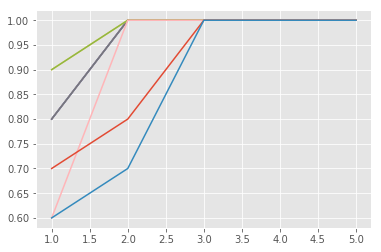

In [217]:
NRUNS = 1
experiment_results = []

for ex in experiments:
    print(ex)
    sys.stdout.flush()
    acc_tot = np.zeros((NRUNS, NBLOCKS))
    for i in tqdm(range(NRUNS)):
        pred_blocks = run_experiment(ex, feat_type='z')
        acc_blocks = [float(sum(map(lambda x: int(x[0] == x[1]), block))) / float(len(block)) for block in pred_blocks]
        acc_tot[i] = np.array(acc_blocks).reshape(1, -1)
        
    experiment_results.append(acc_tot)
    plt.plot(range(1, NBLOCKS+1), np.mean(acc_tot, axis=0))

In [219]:
experiment_results

[array([[0.8, 1. , 1. , 1. , 1. ]]),
 array([[0.8, 1. , 1. , 1. , 1. ]]),
 array([[0.8, 1. , 1. , 1. , 1. ]]),
 array([[0.8, 1. , 1. , 1. , 1. ]]),
 array([[0.9, 1. , 1. , 1. , 1. ]]),
 array([[0.9, 1. , 1. , 1. , 1. ]]),
 array([[0.6, 1. , 1. , 1. , 1. ]]),
 array([[0.7, 0.8, 1. , 1. , 1. ]]),
 array([[0.6, 0.7, 1. , 1. , 1. ]])]

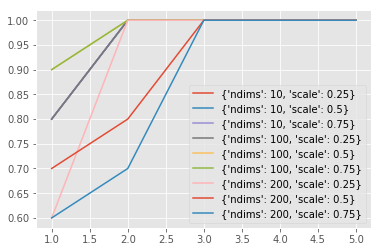

In [227]:
plt.figure()

for i, r in enumerate(experiment_results):
    plt.plot(range(1, NBLOCKS+1), np.mean(r, axis=0), label=experiments[i])
    
plt.legend()
plt.show()